# Emotion Detection - EDA

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [3]:
# define paths
DATA_DIR = '../data/raw'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [4]:
# emotion classes
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

## 1. Class Distribution Analysis

In [5]:
def count_images_per_class(base_dir):
    """Count number of images in each emotion class"""
    class_counts = {}
    for emotion in EMOTIONS:
        emotion_dir = os.path.join(base_dir, emotion)
        if os.path.exists(emotion_dir):
            count = len([f for f in os.listdir(emotion_dir)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[emotion] = count
        else:
            class_counts[emotion] = 0
    return class_counts

In [6]:
# count images in train and test sets
train_counts = count_images_per_class(TRAIN_DIR)
test_counts = count_images_per_class(TEST_DIR)

In [7]:
# create dataframe
df_counts = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts
})
df_counts['Total'] = df_counts['Train'] + df_counts['Test']
df_counts['Train %'] = (df_counts['Train'] / df_counts['Train'].sum() * 100).round(2)
df_counts['Test %'] = (df_counts['Test'] / df_counts['Test'].sum() * 100).round(2)

In [8]:
print("\nClass Distribution Summary:")
print(df_counts)
print(f"\nTotal training images: {df_counts['Train'].sum()}")
print(f"Total test images: {df_counts['Test'].sum()}")
print(f"Total dataset size: {df_counts['Total'].sum()}")


Class Distribution Summary:
          Train  Test  Total  Train %  Test %
angry      3995   958   4953    13.92   13.35
disgust     436   111    547     1.52    1.55
fear       4097  1024   5121    14.27   14.27
happy      7215  1774   8989    25.13   24.71
neutral    4965  1233   6198    17.29   17.18
sad        4830  1247   6077    16.82   17.37
surprise   3171   831   4002    11.05   11.58

Total training images: 28709
Total test images: 7178
Total dataset size: 35887


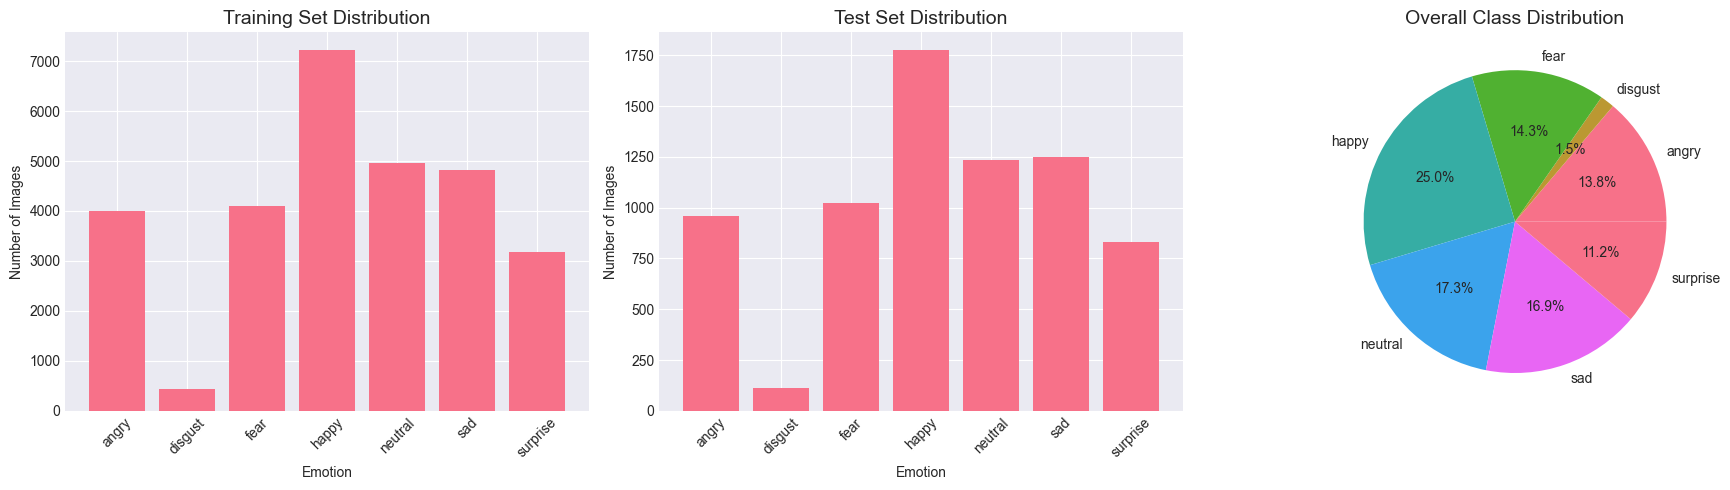

In [9]:
# visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# train set distribution
axes[0].bar(EMOTIONS, df_counts['Train'])
axes[0].set_title('Training Set Distribution', fontsize=14)
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

# test set distribution
axes[1].bar(EMOTIONS, df_counts['Test'])
axes[1].set_title('Test Set Distribution', fontsize=14)
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=45)

# combined pie chart
axes[2].pie(df_counts['Total'], labels=EMOTIONS, autopct='%1.1f%%')
axes[2].set_title('Overall Class Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
# check class imbalance
print("CLASS IMBALANCE ANALYSIS:")
print(f"Most common class: {df_counts['Total'].idxmax()} ({df_counts['Total'].max()} images)")
print(f"Least common class: {df_counts['Total'].idxmin()} ({df_counts['Total'].min()} images)")
print(f"Imbalance ratio: {df_counts['Total'].max() / df_counts['Total'].min():.2f}:1")

CLASS IMBALANCE ANALYSIS:
Most common class: happy (8989 images)
Least common class: disgust (547 images)
Imbalance ratio: 16.43:1


## 2. Image Quality Assessment

In [12]:
def analyze_image_properties(base_dir, sample_size=100):
    """Analyze image properties like dimensions, channels, brightness"""
    properties = {
        'widths': [],
        'heights': [],
        'channels': [],
        'brightness': [],
        'contrast': [],
        'file_sizes': [],
        'formats': defaultdict(int)
    }

    corrupted_images = []

    for emotion in EMOTIONS:
        emotion_dir = os.path.join(base_dir, emotion)
        if not os.path.exists(emotion_dir):
            continue

        image_files = [f for f in os.listdir(emotion_dir)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # sample images for analysis
        sample_files = np.random.choice(image_files,
                                        min(sample_size, len(image_files)),
                                        replace=False)
        
        for img_file in sample_files:
            img_path = os.path.join(emotion_dir, img_file)

            try:
                # get file size
                file_size = os.path.getsize(img_path) / 1024    # KB
                properties['file_sizes'].append(file_size)

                # open with PIL for basic properties
                img_pil = Image.open(img_path)
                properties['formats'][img_pil.format] += 1

                # convert to numpy array for analysis
                img_np = np.array(img_pil)

                # image dimensions
                if len(img_np.shape) == 2:  # grayscale
                    h, w = img_np.shape
                    channels = 1
                else:   # color
                    h, w, channels = img_np.shape

                properties['widths'].append(w)
                properties['heights'].append(h)
                properties['channels'].append(channels)

                # calculate brightness (mean pixel value)
                if channels == 1:
                    brightness = np.mean(img_np)
                else:
                    # convert to grayscale for brightness
                    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
                    brightness = np.mean(gray)
                properties['brightness'].append(brightness)

                # calculate contrast (standard deviation)
                if channels == 1:
                    contrast = np.std(img_np)
                else:
                    contrast = np.std(gray)
                properties['contrast'].append(contrast)

            except Exception as e:
                corrupted_images.append((emotion, img_file, str(e)))

    return properties, corrupted_images

In [13]:
# analyze training set properties
train_props, train_corrupted = analyze_image_properties(TRAIN_DIR, sample_size=200)

In [14]:
print("\nImage Properties Summary:")
print(f"Image dimensions: {set(zip(train_props['widths'], train_props['heights']))}")
print(f"Unique widths: {set(train_props['widths'])}")
print(f"Unique heights: {set(train_props['heights'])}")
print(f"Channel distribution: {dict(pd.Series(train_props['channels']).value_counts())}")
print(f"Image formats: {dict(train_props['formats'])}")
print(f"\nCorrupted/unreadable images: {len(train_corrupted)}")


Image Properties Summary:
Image dimensions: {(48, 48)}
Unique widths: {48}
Unique heights: {48}
Channel distribution: {1: 1400}
Image formats: {'JPEG': 1400}

Corrupted/unreadable images: 0


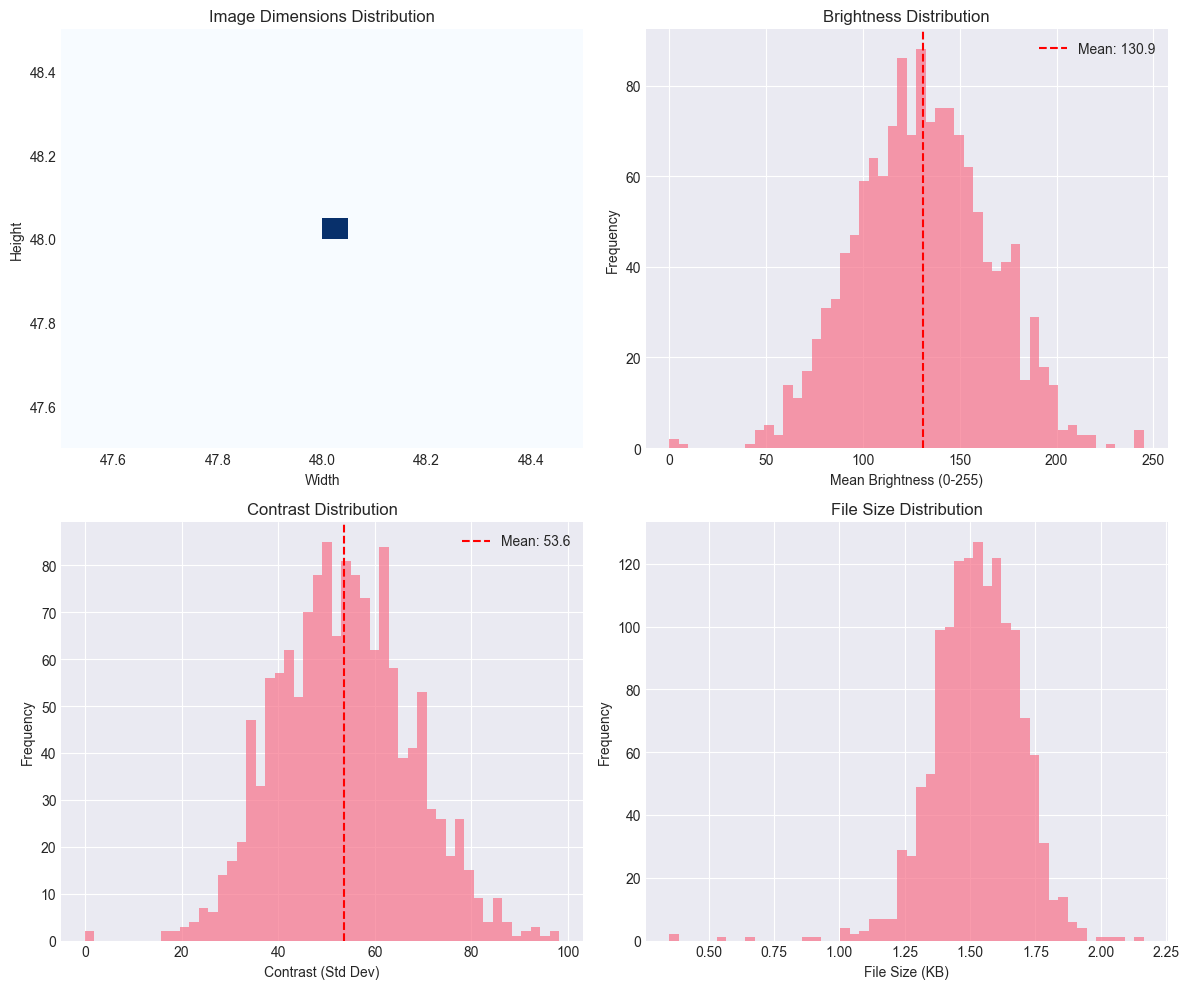

In [15]:
# visualize image properties
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# image dimensions
axes[0, 0].hist2d(train_props['widths'], train_props['heights'], bins=20, cmap='Blues')
axes[0, 0].set_xlabel('Width')
axes[0, 0].set_ylabel('Height')
axes[0, 0].set_title('Image Dimensions Distribution')

# brightness distribution
axes[0, 1].hist(train_props['brightness'], bins=50, alpha=0.7)
axes[0, 1].set_xlabel('Mean Brightness (0-255)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Brightness Distribution')
axes[0, 1].axvline(np.mean(train_props['brightness']), color='red', 
                   linestyle='--', label=f'Mean: {np.mean(train_props["brightness"]):.1f}')
axes[0, 1].legend()

# contrast distribution
axes[1, 0].hist(train_props['contrast'], bins=50, alpha=0.7)
axes[1, 0].set_xlabel('Contrast (Std Dev)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Contrast Distribution')
axes[1, 0].axvline(np.mean(train_props['contrast']), color='red', 
                   linestyle='--', label=f'Mean: {np.mean(train_props["contrast"]):.1f}')
axes[1, 0].legend()

# file size distribution
axes[1, 1].hist(train_props['file_sizes'], bins=50, alpha=0.7)
axes[1, 1].set_xlabel('File Size (KB)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('File Size Distribution')

plt.tight_layout()
plt.show()

## 3. Sample Images Visualization

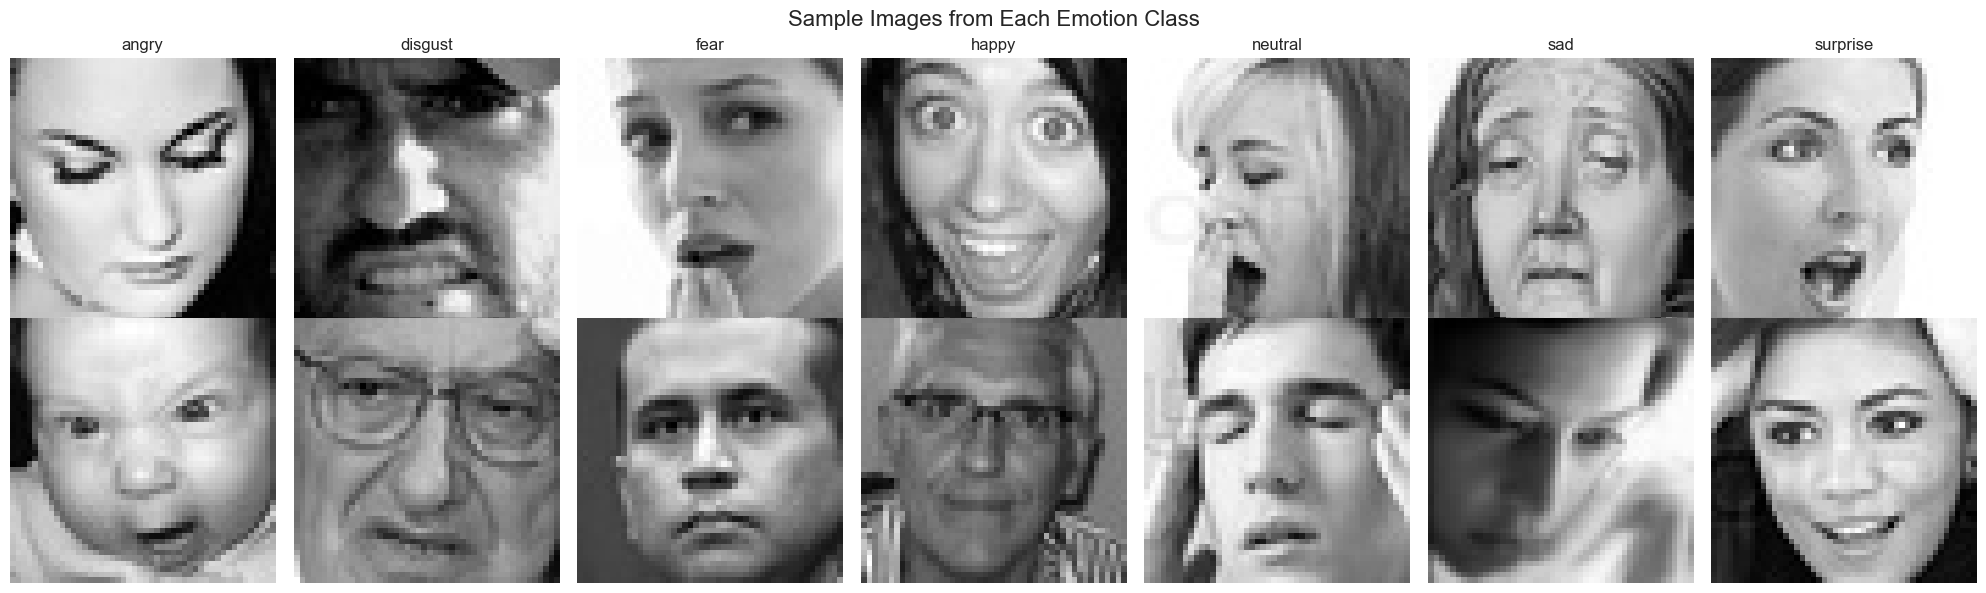

In [16]:
fig, axes = plt.subplots(2, 7, figsize=(20, 6))
fig.suptitle('Sample Images from Each Emotion Class', fontsize=16)

for idx, emotion in enumerate(EMOTIONS):
    emotion_dir = os.path.join(TRAIN_DIR, emotion)
    if not os.path.exists(emotion_dir):
        continue

    image_files = [f for f in os.listdir(emotion_dir) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # get two random samples
    sample_files = np.random.choice(image_files, min(2, len(image_files)), replace=False)

    for i, img_file in enumerate(sample_files):
        img_path = os.path.join(emotion_dir, img_file)
        try:
            img = Image.open(img_path)
            axes[i, idx].imshow(img, cmap='gray' if img.mode == 'L' else None)
            axes[i, idx].axis('off')
            if i == 0:
                axes[i, idx].set_title(emotion, fontsize=12)
        except:
            axes[i, idx].text(0.5, 0.5, 'Error', ha='center', va='center')
            axes[i, idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Outlier Detection

In [17]:
# identify potential outliers based on brightness and contrast
brightness_mean = np.mean(train_props['brightness'])
brightness_std = np.std(train_props['brightness'])
contrast_mean = np.mean(train_props['contrast'])
contrast_std = np.std(train_props['contrast'])

In [18]:
# define outliers as images beyond 3 standard deviations
brightness_outliers = [i for i, b in enumerate(train_props['brightness']) 
                      if abs(b - brightness_mean) > 3 * brightness_std]
contrast_outliers = [i for i, c in enumerate(train_props['contrast']) 
                    if abs(c - contrast_mean) > 3 * contrast_std]


In [19]:
print(f"Brightness outliers: {len(brightness_outliers)} images")
print(f"Contrast outliers: {len(contrast_outliers)} images")

Brightness outliers: 7 images
Contrast outliers: 4 images


## 5. Face Detection Check

In [20]:
# load OpenCV face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [21]:
def check_face_detection(base_dir, sample_size=50):
    """Check if faces are detected and their positions"""
    face_stats = {
        'no_face': 0,
        'single_face': 0,
        'multiple_faces': 0,
        'face_positions': []
    }

    for emotion in EMOTIONS:
        emotion_dir = os.path.join(base_dir, emotion)
        if not os.path.exists(emotion_dir):
            continue

        image_files = [f for f in os.listdir(emotion_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        sample_files = np.random.choice(image_files, 
                                      min(sample_size, len(image_files)), 
                                      replace=False)
        
        for img_file in sample_files:
            img_path = os.path.join(emotion_dir, img_file)

            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img

                # detect faces
                faces = face_cascade.detectMultiScale(gray, 1.1, 4)

                if len(faces) == 0:
                    face_stats['no_face'] += 1
                elif len(faces) == 1:
                    face_stats['single_face'] += 1
                    x, y, w, h = faces[0]
                    # calculate face position relative to image
                    img_h, img_w = gray.shape
                    face_center_x = (x + w/2) / img_w
                    face_center_y = (y + h/2) / img_h
                    face_size = (w * h) / (img_w * img_h)
                    face_stats['face_positions'].append({
                        'center_x': face_center_x,
                        'center_y': face_center_y,
                        'relative_size': face_size
                    })
                else:
                    face_stats['multiple_faces'] += 1

            except Exception as e:
                continue

    return face_stats


In [22]:
face_results = check_face_detection(TRAIN_DIR, sample_size=100)

In [23]:
total_checked = sum([face_results['no_face'], face_results['single_face'], face_results['multiple_faces']])
print(f"\nFace Detection Results (sample of {total_checked} images):")
print(f"Images with no face detected: {face_results['no_face']} ({face_results['no_face']/total_checked*100:.1f}%)")
print(f"Images with single face: {face_results['single_face']} ({face_results['single_face']/total_checked*100:.1f}%)")
print(f"Images with multiple faces: {face_results['multiple_faces']} ({face_results['multiple_faces']/total_checked*100:.1f}%)")


Face Detection Results (sample of 700 images):
Images with no face detected: 477 (68.1%)
Images with single face: 223 (31.9%)
Images with multiple faces: 0 (0.0%)
